In [1]:
from numba import njit
from hftbacktest import BUY_EVENT

import numpy as np

@njit
def measure_trading_intensity_and_volatility(hbt):
    tick_size = hbt.depth(0).tick_size
    arrival_depth = np.full(10_000_000, np.nan, np.float64)
    mid_price_chg = np.full(10_000_000, np.nan, np.float64)

    t = 0
    prev_mid_price_tick = np.nan
    mid_price_tick = np.nan

    # Checks every 100 milliseconds.
    while hbt.elapse(100_000_000) == 0:
        #--------------------------------------------------------
        # Records market order's arrival depth from the mid-price.
        if not np.isnan(mid_price_tick):
            depth = -np.inf
            for last_trade in hbt.last_trades(0):
                trade_price_tick = last_trade.px / tick_size

                if last_trade.ev & BUY_EVENT == BUY_EVENT:
                    depth = np.nanmax([trade_price_tick - mid_price_tick, depth])
                else:
                    depth = np.nanmax([mid_price_tick - trade_price_tick, depth])
            arrival_depth[t] = depth

        hbt.clear_last_trades(0)

        depth = hbt.depth(0)

        best_bid_tick = depth.best_bid_tick
        best_ask_tick = depth.best_ask_tick

        prev_mid_price_tick = mid_price_tick
        mid_price_tick = (best_bid_tick + best_ask_tick) / 2.0

        # Records the mid-price change for volatility calculation.
        mid_price_chg[t] = mid_price_tick - prev_mid_price_tick

        t += 1
        if t >= len(arrival_depth) or t >= len(mid_price_chg):
            raise Exception
    return arrival_depth[:t], mid_price_chg[:t]

In [2]:
@njit
def measure_trading_intensity(order_arrival_depth, out):
    max_tick = 0
    for depth in order_arrival_depth:
        if not np.isfinite(depth):
            continue

        # Sets the tick index to 0 for the nearest possible best price
        # as the order arrival depth in ticks is measured from the mid-price
        tick = round(depth / .5) - 1

        # In a fast-moving market, buy trades can occur below the mid-price (and vice versa for sell trades)
        # since the mid-price is measured in a previous time-step;
        # however, to simplify the problem, we will exclude those cases.
        if tick < 0 or tick >= len(out):
            continue

        # All of our possible quotes within the order arrival depth,
        # excluding those at the same price, are considered executed.
        out[:tick] += 1

        max_tick = max(max_tick, tick)
    return out[:max_tick]

In [3]:
from hftbacktest import BacktestAsset, ROIVectorMarketDepthBacktest

asset = (
    BacktestAsset()
        .data([
            'data/binance_future/solusdt_20251011.npz'
        ])
        .initial_snapshot('data/binance_future/solusdt_20251010_eod.npz')
        .linear_asset(1.0)
        .intp_order_latency([
            'data/binance_future/solusdt_20251011_feed_latency.npz'
        ])
        .power_prob_queue_model(2.0)
        .no_partial_fill_exchange()
        .trading_value_fee_model(0.0000, 0.0003)
        .tick_size(0.01)
        .lot_size(0.01)
        .roi_lb(0.0)
        .roi_ub(300.0)
        .last_trades_capacity(10000)
)

hbt = ROIVectorMarketDepthBacktest([asset])

arrival_depth, mid_price_chg = measure_trading_intensity_and_volatility(hbt)

_ = hbt.close()

In [4]:
tmp = np.zeros(500, np.float64)

# Measures trading intensity (lambda) for the first 10-minute window.
lambda_ = measure_trading_intensity(arrival_depth[:6_000], tmp)

# Since it is measured for a 10-minute window, divide by 600 to convert it to per second.
lambda_ /= 600

# Creates ticks from the mid-price.
ticks = np.arange(len(lambda_)) + .5

Text(0, 0.5, 'Count (per second)')

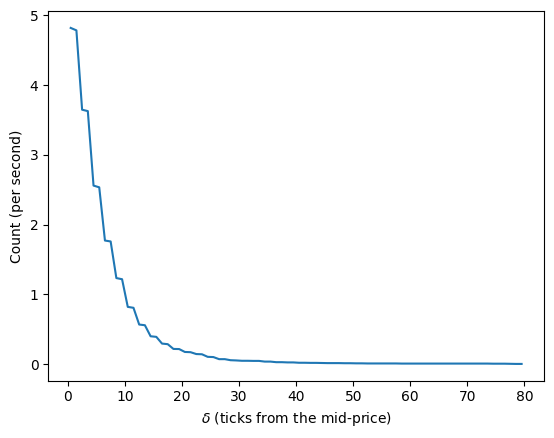

In [5]:
from matplotlib import pyplot as plt

plt.plot(ticks, lambda_)
plt.xlabel('$ \delta $ (ticks from the mid-price)')
plt.ylabel('Count (per second)')

In [6]:
@njit
def linear_regression(x, y):
    sx = np.sum(x)
    sy = np.sum(y)
    sx2 = np.sum(x ** 2)
    sxy = np.sum(x * y)
    w = len(x)
    slope = (w * sxy - sx * sy) / (w * sx2 - sx**2)
    intercept = (sy - slope * sx) / w
    return slope, intercept

In [7]:
y = np.log(lambda_)
k_, logA = linear_regression(ticks, y)
A = np.exp(logA)
k = -k_

print('A={}, k={}'.format(A, k))

A=1.4297262528550163, k=0.08755282311158494


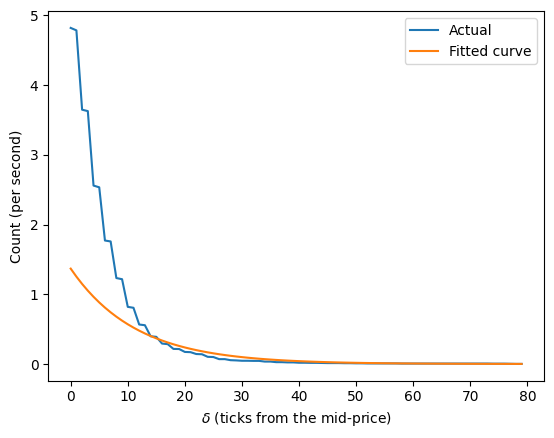

In [8]:
plt.plot(lambda_)
plt.plot(A * np.exp(-k * ticks))
plt.xlabel('$ \delta $ (ticks from the mid-price)')
plt.ylabel('Count (per second)')
plt.legend(['Actual', 'Fitted curve'])

In [9]:
# Refits for the range un to 70 ticks.
x_shallow = ticks[:20]
lambda_shallow = lambda_[:20]

y = np.log(lambda_shallow)
k_, logA = linear_regression(x_shallow, y)
A = np.exp(logA)
k = -k_

print('A={}, k={}'.format(A, k))

A=5.918530652802602, k=0.17702405201698845


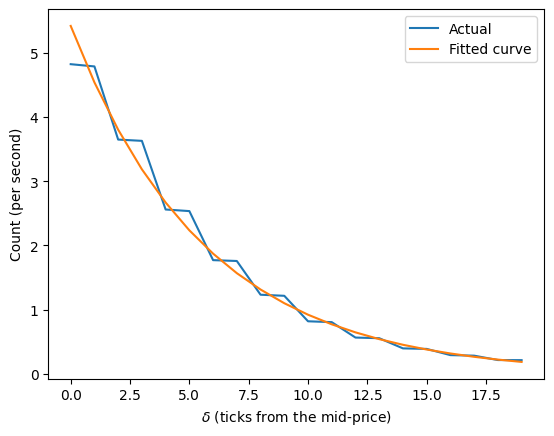

In [10]:
plt.plot(lambda_shallow)
plt.plot(A * np.exp(-k * x_shallow))
plt.xlabel('$ \delta $ (ticks from the mid-price)')
plt.ylabel('Count (per second)')
plt.legend(['Actual', 'Fitted curve'])

In [11]:
# Since we need volatility in ticks per square root of a second and our measurement is every 100ms,
# multiply by the square root of 10.
volatility = np.nanstd(mid_price_chg) * np.sqrt(10)
print(volatility)


3.623775922420444


In [12]:
@njit
def compute_coeff(xi, gamma, delta, A, k):
    inv_k = np.divide(1, k)
    c1 = 1 / (xi * delta) * np.log(1 + xi * delta * inv_k)
    c2 = np.sqrt(np.divide(gamma, 2 * A * delta * k) * ((1 + xi * delta * inv_k) ** (k / (xi * delta) + 1)))
    return c1, c2

In [13]:
gamma = 0.05
delta = 1
volatility = 10.69

c1, c2 = compute_coeff(gamma, gamma, delta, A, k)

half_spread_tick = 1 * c1 + 1 / 2 * c2 * volatility
skew = c2 * volatility
print('half_spread_tick={}, skew={}'.format(half_spread_tick, skew))

half_spread_tick=6.42775446851053, skew=2.9046946391493615


In [14]:
from scipy import stats

# inverse of percentile
pct = stats.percentileofscore(arrival_depth[np.isfinite(arrival_depth)], half_spread_tick)
your_pct = 100 - pct
print('{:.2f}%'.format(your_pct))

1.22%


In [15]:
from numba.typed import Dict
from hftbacktest import BUY, SELL, GTX, LIMIT

out_dtype = np.dtype([
    ('half_spread_tick', 'f8'),
    ('skew', 'f8'),
    ('volatility', 'f8'),
    ('A', 'f8'),
    ('k', 'f8')
])

@njit
def glft_market_maker(hbt, recorder):
    tick_size = hbt.depth(0).tick_size
    arrival_depth = np.full(10_000_000, np.nan, np.float64)
    mid_price_chg = np.full(10_000_000, np.nan, np.float64)
    out = np.zeros(10_000_000, out_dtype)

    t = 0
    prev_mid_price_tick = np.nan
    mid_price_tick = np.nan

    tmp = np.zeros(500, np.float64)
    ticks = np.arange(len(tmp)) + 0.5

    A = np.nan
    k = np.nan
    volatility = np.nan
    gamma = 0.05
    delta = 1
    adj1 = 1
    adj2 = 0.05 # Uses the same value as gamma.

    order_qty = 1
    max_position = 20

    # Checks every 100 milliseconds.
    while hbt.elapse(100_000_000) == 0:
        #--------------------------------------------------------
        # Records market order's arrival depth from the mid-price.
        if not np.isnan(mid_price_tick):
            depth = -np.inf
            for last_trade in hbt.last_trades(0):
                trade_price_tick = last_trade.px / tick_size

                if last_trade.ev & BUY_EVENT == BUY_EVENT:
                    depth = np.nanmax([trade_price_tick - mid_price_tick, depth])
                else:
                    depth = np.nanmax([mid_price_tick - trade_price_tick, depth])
            arrival_depth[t] = depth

        hbt.clear_last_trades(0)
        hbt.clear_inactive_orders(0)

        depth = hbt.depth(0)
        position = hbt.position(0)
        orders = hbt.orders(0)

        best_bid_tick = depth.best_bid_tick
        best_ask_tick = depth.best_ask_tick

        prev_mid_price_tick = mid_price_tick
        mid_price_tick = (best_bid_tick + best_ask_tick) / 2.0

        # Records the mid-price change for volatility calculation.
        mid_price_chg[t] = mid_price_tick - prev_mid_price_tick

        #--------------------------------------------------------
        # Calibrates A, k and calculates the market volatility.

        # Updates A, k, and the volatility every 5-sec.
        if t % 50 == 0:
            # Window size is 10-minute.
            if t >= 6_000 - 1:
                # Calibrates A, k
                tmp[:] = 0
                lambda_ = measure_trading_intensity(arrival_depth[t + 1 - 6_000:t + 1], tmp)
                if len(lambda_) > 2:
                    lambda_ = lambda_[:70] / 600
                    x = ticks[:len(lambda_)]
                    y = np.log(lambda_)
                    k_, logA = linear_regression(x, y)
                    A = np.exp(logA)
                    k = -k_

                # Updates the volatility.
                volatility = np.nanstd(mid_price_chg[t + 1 - 6_000:t + 1]) * np.sqrt(10)

        #--------------------------------------------------------
        # Computes bid price and ask price.

        c1, c2 = compute_coeff(gamma, gamma, delta, A, k)

        half_spread_tick = (c1 + delta / 2 * c2 * volatility) * adj1
        skew = c2 * volatility * adj2

        reservation_price_tick = mid_price_tick - skew * position

        bid_price_tick = np.minimum(np.round(reservation_price_tick - half_spread_tick), best_bid_tick)
        ask_price_tick = np.maximum(np.round(reservation_price_tick + half_spread_tick), best_ask_tick)

        bid_price = bid_price_tick * tick_size
        ask_price = ask_price_tick * tick_size

        #--------------------------------------------------------
        # Updates quotes.

        # Cancel orders if they differ from the updated bid and ask prices.
        order_values = orders.values();
        while order_values.has_next():
            order = order_values.get()
            # Cancels if a working order is not in the new grid.
            if order.cancellable:
                if (
                    (order.side == BUY and order.price_tick != bid_price_tick)
                    or (order.side == SELL and order.price_tick != ask_price_tick)
                ):
                    hbt.cancel(0, order.order_id, False)

        # If the current position is within the maximum position,
        # submit the new order only if no order exists at the same price.
        if position < max_position and np.isfinite(bid_price):
            bid_price_as_order_id = round(bid_price / tick_size)
            if bid_price_as_order_id not in orders:
                hbt.submit_buy_order(0, bid_price_as_order_id, bid_price, order_qty, GTX, LIMIT, False)
        if position > -max_position and np.isfinite(ask_price):
            ask_price_as_order_id = round(ask_price / tick_size)
            if ask_price_as_order_id not in orders:
                hbt.submit_sell_order(0, ask_price_as_order_id, ask_price, order_qty, GTX, LIMIT, False)

        #--------------------------------------------------------
        # Records variables and stats for analysis.

        out[t].half_spread_tick = half_spread_tick
        out[t].skew = skew
        out[t].volatility = volatility
        out[t].A = A
        out[t].k = k

        t += 1

        if t >= len(arrival_depth) or t >= len(mid_price_chg) or t >= len(out):
            raise Exception

        # Records the current state for stat calculation.
        recorder.record(hbt)
    return out[:t]

In [16]:
from hftbacktest import Recorder
from hftbacktest.stats import LinearAssetRecord

asset = (
    BacktestAsset()
        .data([
            'data/binance_future/solusdt_20251011.npz'
        ])
        .initial_snapshot('data/binance_future/solusdt_20251010_eod.npz')
        .linear_asset(1.0)
        .intp_order_latency([
            'data/binance_future/solusdt_20251011_feed_latency.npz'
        ])
        .power_prob_queue_model(2.0)
        .no_partial_fill_exchange()
        .trading_value_fee_model(-0.0001, 0.0003)
        .tick_size(0.01)
        .lot_size(0.01)
        .roi_lb(0.0)
        .roi_ub(300.0)
        .last_trades_capacity(10000)
)

hbt = ROIVectorMarketDepthBacktest([asset])

recorder = Recorder(1, 5_000_000)

out = glft_market_maker(hbt, recorder.recorder)

hbt.close()

stats = LinearAssetRecord(recorder.get(0)).stats(book_size=30_000)
stats.summary()

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-10-11 00:00:00,2025-10-11 23:59:50,-11.04715,-14.201133,-0.001469,0.003779,15110.748929,91.624221,-0.3889,-0.000016,3362.85


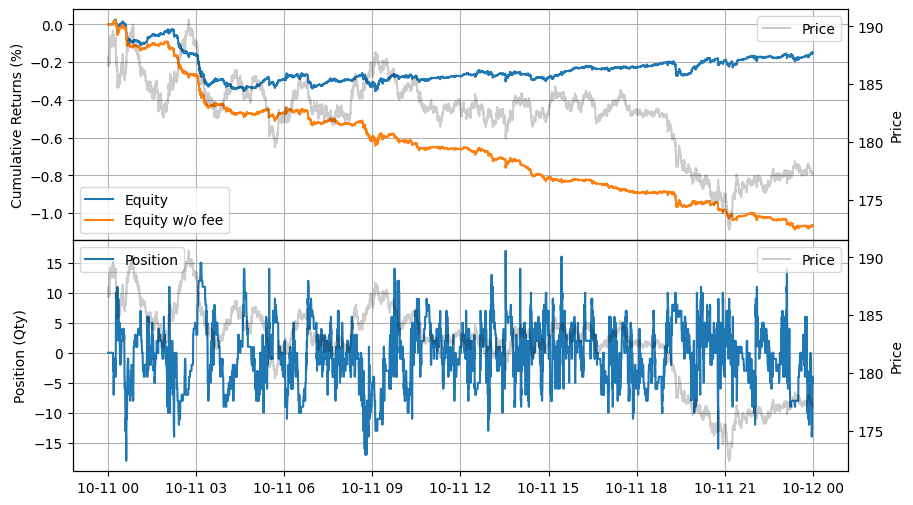

In [17]:
stats.plot()


In [18]:
from numba.typed import Dict
from numba import uint64

@njit
def gridtrading_glft_mm(hbt, recorder):
    asset_no = 0
    tick_size = hbt.depth(asset_no).tick_size

    arrival_depth = np.full(10_000_000, np.nan, np.float64)
    mid_price_chg = np.full(10_000_000, np.nan, np.float64)

    t = 0
    prev_mid_price_tick = np.nan
    mid_price_tick = np.nan

    tmp = np.zeros(500, np.float64)
    ticks = np.arange(len(tmp)) + 0.5

    A = np.nan
    k = np.nan
    volatility = np.nan
    gamma = 0.05
    delta = 1
    adj1 = 1
    adj2 = 0.05

    order_qty = 1
    max_position = 20
    grid_num = 20

    # Checks every 100 milliseconds.
    while hbt.elapse(100_000_000) == 0:
        #--------------------------------------------------------
        # Records market order's arrival depth from the mid-price.
        if not np.isnan(mid_price_tick):
            depth = -np.inf
            for last_trade in hbt.last_trades(asset_no):
                trade_price_tick = last_trade.px / tick_size

                if last_trade.ev & BUY_EVENT == BUY_EVENT:
                    depth = np.nanmax([trade_price_tick - mid_price_tick, depth])
                else:
                    depth = np.nanmax([mid_price_tick - trade_price_tick, depth])
            arrival_depth[t] = depth

        hbt.clear_last_trades(asset_no)
        hbt.clear_inactive_orders(asset_no)

        depth = hbt.depth(asset_no)
        position = hbt.position(asset_no)
        orders = hbt.orders(asset_no)

        best_bid_tick = depth.best_bid_tick
        best_ask_tick = depth.best_ask_tick

        prev_mid_price_tick = mid_price_tick
        mid_price_tick = (best_bid_tick + best_ask_tick) / 2.0

        # Records the mid-price change for volatility calculation.
        mid_price_chg[t] = mid_price_tick - prev_mid_price_tick

        #--------------------------------------------------------
        # Calibrates A, k and calculates the market volatility.

        # Updates A, k, and the volatility every 5-sec.
        if t % 50 == 0:
            # Window size is 10-minute.
            if t >= 6_000 - 1:
                # Calibrates A, k
                tmp[:] = 0
                lambda_ = measure_trading_intensity(arrival_depth[t + 1 - 6_000:t + 1], tmp)
                if len(lambda_) > 2:
                    lambda_ = lambda_[:70] / 600
                    x = ticks[:len(lambda_)]
                    y = np.log(lambda_)
                    k_, logA = linear_regression(x, y)
                    A = np.exp(logA)
                    k = -k_

                # Updates the volatility.
                volatility = np.nanstd(mid_price_chg[t + 1 - 6_000:t + 1]) * np.sqrt(10)

        #--------------------------------------------------------
        # Computes bid price and ask price.

        c1, c2 = compute_coeff(gamma, gamma, delta, A, k)

        half_spread_tick = (c1 + delta / 2 * c2 * volatility) * adj1
        skew = c2 * volatility * adj2

        reservation_price_tick = mid_price_tick - skew * position

        bid_price_tick = np.minimum(np.round(reservation_price_tick - half_spread_tick), best_bid_tick)
        ask_price_tick = np.maximum(np.round(reservation_price_tick + half_spread_tick), best_ask_tick)

        bid_price = bid_price_tick * tick_size
        ask_price = ask_price_tick * tick_size

        grid_interval = max(np.round(half_spread_tick) * tick_size, tick_size)

        bid_price = np.floor(bid_price / grid_interval) * grid_interval
        ask_price = np.ceil(ask_price / grid_interval) * grid_interval

        #--------------------------------------------------------
        # Updates quotes.

        # Creates a new grid for buy orders.
        new_bid_orders = Dict.empty(np.uint64, np.float64)
        if position < max_position and np.isfinite(bid_price):
            for i in range(grid_num):
                bid_price_tick = round(bid_price / tick_size)

                # order price in tick is used as order id.
                new_bid_orders[uint64(bid_price_tick)] = bid_price

                bid_price -= grid_interval

        # Creates a new grid for sell orders.
        new_ask_orders = Dict.empty(np.uint64, np.float64)
        if position > -max_position and np.isfinite(ask_price):
            for i in range(grid_num):
                ask_price_tick = round(ask_price / tick_size)

                # order price in tick is used as order id.
                new_ask_orders[uint64(ask_price_tick)] = ask_price

                ask_price += grid_interval

        order_values = orders.values();
        while order_values.has_next():
            order = order_values.get()
            # Cancels if a working order is not in the new grid.
            if order.cancellable:
                if (
                    (order.side == BUY and order.order_id not in new_bid_orders)
                    or (order.side == SELL and order.order_id not in new_ask_orders)
                ):
                    hbt.cancel(asset_no, order.order_id, False)

        for order_id, order_price in new_bid_orders.items():
            # Posts a new buy order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_buy_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)

        for order_id, order_price in new_ask_orders.items():
            # Posts a new sell order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_sell_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)

        #--------------------------------------------------------
        # Records variables and stats for analysis.

        t += 1

        if t >= len(arrival_depth) or t >= len(mid_price_chg):
            raise Exception

        # Records the current state for stat calculation.
        recorder.record(hbt)
    return out[:t]

In [19]:
from hftbacktest import Recorder
from hftbacktest.stats import LinearAssetRecord

asset = (
    BacktestAsset()
        .data([
            'data/binance_future/solusdt_20251011.npz'
        ])
        .initial_snapshot('data/binance_future/solusdt_20251010_eod.npz')
        .linear_asset(1.0)
        .intp_order_latency([
            'data/binance_future/solusdt_20251011_feed_latency.npz'
        ])
        .power_prob_queue_model(2.0)
        .no_partial_fill_exchange()
        .trading_value_fee_model(-0.0001, 0.0003)
        .tick_size(0.01)
        .lot_size(0.01)
        .roi_lb(50)
        .roi_ub(300.0)
        .last_trades_capacity(10000)
)

hbt = ROIVectorMarketDepthBacktest([asset])

recorder = Recorder(1, 5_000_000)

out = gridtrading_glft_mm(hbt, recorder.recorder)

hbt.close()

stats = LinearAssetRecord(recorder.get(0)).stats(book_size=30_000)
stats.summary()

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-10-11 00:00:00,2025-10-11 23:59:50,-0.206865,-0.275706,-0.000045,0.004569,9033.045491,54.820384,-0.00976,-8.1359e-7,4247.755


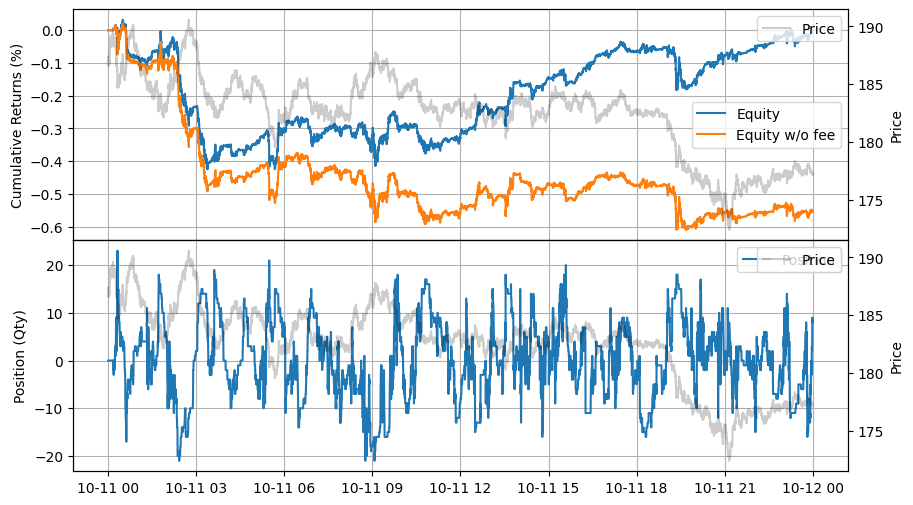

In [20]:
stats.plot()

In [21]:
import numpy as np

from numba import njit, uint64
from numba.typed import Dict

from hftbacktest import (
    BacktestAsset,
    ROIVectorMarketDepthBacktest,
    GTX,
    LIMIT,
    BUY,
    SELL,
    BUY_EVENT,
    SELL_EVENT,
    Recorder
)
from hftbacktest.stats import LinearAssetRecord

@njit
def obi_mm(
    hbt,
    stat,
    half_spread,
    skew,
    c1,
    looking_depth,
    interval,
    window,
    order_qty_dollar,
    max_position_dollar,
    grid_num,
    grid_interval,
    roi_lb,
    roi_ub
):
    asset_no = 0
    imbalance_timeseries = np.full(30_000_000, np.nan, np.float64)

    tick_size = hbt.depth(0).tick_size
    lot_size = hbt.depth(0).lot_size

    t = 0
    roi_lb_tick = int(round(roi_lb / tick_size))
    roi_ub_tick = int(round(roi_ub / tick_size))

    while hbt.elapse(interval) == 0:
        hbt.clear_inactive_orders(asset_no)

        depth = hbt.depth(asset_no)
        position = hbt.position(asset_no)
        orders = hbt.orders(asset_no)

        best_bid = depth.best_bid
        best_ask = depth.best_ask

        mid_price = (best_bid + best_ask) / 2.0

        sum_ask_qty = 0.0
        from_tick = max(depth.best_ask_tick, roi_lb_tick)
        upto_tick = min(int(np.floor(mid_price * (1 + looking_depth) / tick_size)), roi_ub_tick)
        for price_tick in range(from_tick, upto_tick):
            sum_ask_qty += depth.ask_depth[price_tick - roi_lb_tick]

        sum_bid_qty = 0.0
        from_tick = min(depth.best_bid_tick, roi_ub_tick)
        upto_tick = max(int(np.ceil(mid_price * (1 - looking_depth) / tick_size)), roi_lb_tick)
        for price_tick in range(from_tick, upto_tick, -1):
            sum_bid_qty += depth.bid_depth[price_tick - roi_lb_tick]

        imbalance_timeseries[t] = sum_bid_qty - sum_ask_qty

        # Standardizes the order book imbalance timeseries for a given window
        m = np.nanmean(imbalance_timeseries[max(0, t + 1 - window):t + 1])
        s = np.nanstd(imbalance_timeseries[max(0, t + 1 - window):t + 1])
        alpha = np.divide(imbalance_timeseries[t] - m, s)

        #--------------------------------------------------------
        # Computes bid price and ask price.

        order_qty = max(round((order_qty_dollar / mid_price) / lot_size) * lot_size, lot_size)
        fair_price = mid_price + c1 * alpha

        normalized_position = position / order_qty

        reservation_price = fair_price - skew * normalized_position

        bid_price = min(np.round(reservation_price - half_spread), best_bid)
        ask_price = max(np.round(reservation_price + half_spread), best_ask)

        bid_price = np.floor(bid_price / tick_size) * tick_size
        ask_price = np.ceil(ask_price / tick_size) * tick_size

        #--------------------------------------------------------
        # Updates quotes.

        # Creates a new grid for buy orders.
        new_bid_orders = Dict.empty(np.uint64, np.float64)
        if position * mid_price < max_position_dollar and np.isfinite(bid_price):
            for i in range(grid_num):
                bid_price_tick = round(bid_price / tick_size)

                # order price in tick is used as order id.
                new_bid_orders[uint64(bid_price_tick)] = bid_price

                bid_price -= grid_interval

        # Creates a new grid for sell orders.
        new_ask_orders = Dict.empty(np.uint64, np.float64)
        if position * mid_price > -max_position_dollar and np.isfinite(ask_price):
            for i in range(grid_num):
                ask_price_tick = round(ask_price / tick_size)

                # order price in tick is used as order id.
                new_ask_orders[uint64(ask_price_tick)] = ask_price

                ask_price += grid_interval

        order_values = orders.values();
        while order_values.has_next():
            order = order_values.get()
            # Cancels if a working order is not in the new grid.
            if order.cancellable:
                if (
                    (order.side == BUY and order.order_id not in new_bid_orders)
                    or (order.side == SELL and order.order_id not in new_ask_orders)
                ):
                    hbt.cancel(asset_no, order.order_id, False)

        for order_id, order_price in new_bid_orders.items():
            # Posts a new buy order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_buy_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)

        for order_id, order_price in new_ask_orders.items():
            # Posts a new sell order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_sell_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)

        t += 1

        if t >= len(imbalance_timeseries):
            raise Exception

        # Records the current state for stat calculation.
        stat.record(hbt)

In [ ]:
roi_lb = 0
roi_ub = 300

from hftbacktest import Recorder
from hftbacktest.stats import LinearAssetRecord

asset = (
    BacktestAsset()
        .data([
            'data/binance_future/solusdt_20251011.npz'
        ])
        .initial_snapshot('data/binance_future/solusdt_20251010_eod.npz')
        .linear_asset(1.0)
        .intp_order_latency([
            'data/binance_future/solusdt_20251011_feed_latency.npz'
        ])
        .power_prob_queue_model(2.0)
        .no_partial_fill_exchange()
        .trading_value_fee_model(-0.0001, 0.0003)
        .tick_size(0.01)
        .lot_size(0.01)
        .roi_lb(50)
        .roi_ub(300.0)
        .last_trades_capacity(10000)
)

hbt = ROIVectorMarketDepthBacktest([asset])

recorder = Recorder(1, 30_000_000)

half_spread = 1
skew = 0.05
c1 = 5
depth = 0.025 # 2.5% from the mid price
interval = 1_000_000_000 # 1s
window = 3_600_000_000_000 / interval # 1hour
order_qty_dollar = 50
max_position_dollar = order_qty_dollar * 50
grid_num = 1
grid_interval = hbt.depth(0).tick_size


obi_mm(
    hbt,
    recorder.recorder,
    half_spread,
    skew,
    c1,
    depth,
    interval,
    window,
    order_qty_dollar,
    max_position_dollar,
    grid_num,
    grid_interval,
    roi_lb,
    roi_ub
)

hbt.close()

stats = LinearAssetRecord(recorder.get(0)).stats(book_size=30_000)
stats.summary()


start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-10-11 00:00:00,2025-10-11 23:59:50,5.42414,7.518628,0.000721,0.001391,4217.488135,6.994608,0.518605,0.000103,2557.5982


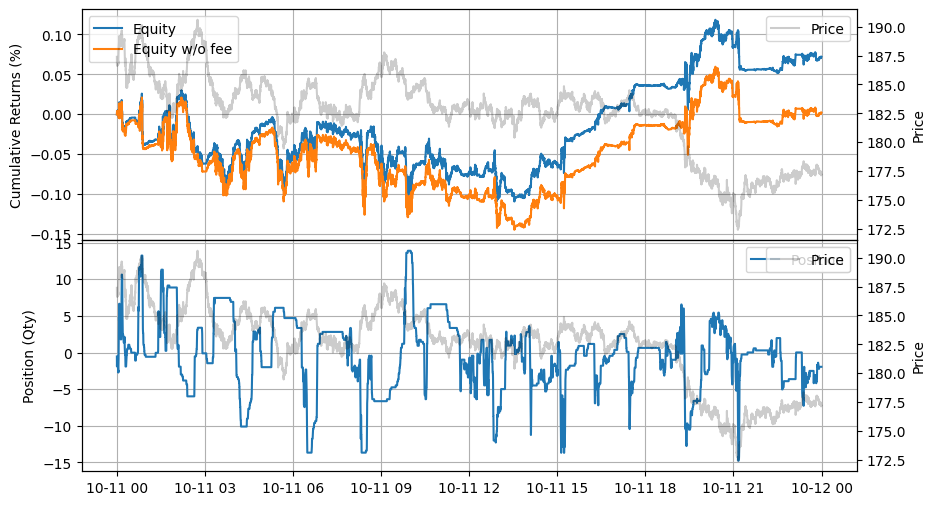

In [118]:
stats.plot()